In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

def display2dArray(arr, title='Data', showBars=True):
    img = plt.imshow(arr, origin='lower', interpolation='none', cmap='gray' )
    plt.title(title)
    if showBars: plt.colorbar(img, cmap='gray')

def displayMaskedImage(maskedImage, showMasks=True, showVariance=False, showBars=True, width=8, height=2.5):
    plt.figure(figsize=(width, height))
    plt.subplot(1, 3, 1)
    ma = maskedImage.getArrays()
    display2dArray(ma[0], title='Data', showBars=showBars)
    if showMasks:
        plt.subplot(1, 3, 2)
        display2dArray(ma[1], title='Masks', showBars=showBars)
    if showVariance:
        plt.subplot(1, 3, 3)
        display2dArray(ma[2], title='Variance', showBars=showBars)
        
def displayExposure(exposure, showMasks=True, showVariance=False, showPsf=False, showBars=True, width=8, height=2.5):
#    plt.figure(figsize=(width, height))
#    plt.subplot(1, 3, 1)
#    ma = exposure.getMaskedImage().getArrays()
#    display2dArray(ma[0], title='Data', showBars=showBars)
#    if showMasks:
#        plt.subplot(1, 3, 2)
#        display2dArray(ma[1], title='Masks', showBars=showBars)
#    if showVariance and not showPsf:
#        plt.subplot(1, 3, 3)
#        display2dArray(ma[2], title='Variance', showBars=showBars)
    displayMaskedImage(exposure.getMaskedImage(), showMasks, showVariance=not showPsf, showBars=showBars, 
                       width=width, height=height)
    if showPsf:
        plt.subplot(1, 3, 3)
        display2dArray(exposure.getPsf().computeImage().getArray(), title='PSF', showBars=showBars)

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim
import lsst.meas.modelfit as measMF

100.0
2.0
5119.79


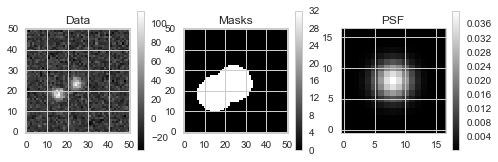

In [66]:
from lsst.meas.base.tests import TestDataset
#from meas_base_tests import TestDataset   ## my slightly modified version
import lsst.afw.geom as afwGeom

def makeStarImage_lsst(w=51, h=51, xc=[15.3], yc=[18.6], flux=[2500], psfSigma=2., noise=1.0, schema=None):
    bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(w-1, h-1))
    dataset = TestDataset(bbox, psfSigma=psfSigma, threshold=1.)
    for i in xrange(len(xc)):
        dataset.addSource(flux=flux[i], centroid=afwGeom.Point2D(xc[i], yc[i]))
    if schema is None:
        schema = TestDataset.makeMinimalSchema()
    exposure, catalog = dataset.realize(noise=noise, schema=schema)
    return exposure, catalog

## Don't put sources too close to the edge!
## Test it on blended sources...
#exposure, catalog = makeStarImage_lsst(xc=[15.3,34.2], yc=[18.6, 33.5], flux=[2500., 2345.], noise=10.)
exposure, catalog = makeStarImage_lsst(xc=[15.3,24.2], yc=[18.6, 23.5], flux=[2500., 2345.], noise=10.)
displayExposure(exposure, showPsf=True)
print exposure.getMaskedImage().getArrays()[2].mean()
print exposure.getPsf().computeShape().getDeterminantRadius()
print exposure.getMaskedImage().getArrays()[0].sum()

Code taken from Jim Bosch's "measurement" bootcamp talk...

https://github.com/lsst-dm/Oct15_bootcamp/blob/measurement/measurement/new-plugin-1.ipynb

In [60]:
import lsst.meas.base
import lsst.pex.config
import lsst.afw.table
import lsst.meas.algorithms
import lsst.meas.deblender

In [67]:
class BoxFluxConfig(lsst.meas.base.SingleFramePluginConfig):
    
    width = lsst.pex.config.Field(
        dtype=int, default=30,
        doc="approximate width of rectangular aperture"
    )

    height = lsst.pex.config.Field(
        dtype=int, default=30,
        doc="approximate height of rectangular aperture"
    )
    
class BoxFluxTransform(lsst.meas.base.FluxTransform):

    def __init__(self, config, name, mapper):
        lsst.meas.base.FluxTransform.__init__(self, name, mapper)
        mapper.addMapping(mapper.getInputSchema().find(name + "_flag_edge").key)

        
## @lsst.meas.base.deregister() doesn't exist, so let's do this first...        
try:    
    del lsst.meas.base.SingleFramePlugin.registry._dict["ext_BoxFlux"]
except:
    pass

@lsst.meas.base.register("ext_BoxFlux")
class BoxFluxPlugin(lsst.meas.base.SingleFramePlugin):

    ConfigClass = BoxFluxConfig
    
    FAILURE_EDGE = 1

    @classmethod
    def getExecutionOrder(cls):
        return cls.FLUX_ORDER

    @classmethod
    def getTransformClass(cls):
        return BoxFluxTransform
    
    def __init__(self, config, name, schema, metadata):
        lsst.meas.base.SingleFramePlugin.__init__(self, config, name, schema, metadata)

        # Get a FunctorKey that can quickly look up the "blessed" centroid value.
        self.centroidKey = lsst.afw.table.Point2DKey(schema["slot_Centroid"])

        # Add some fields for our outputs, and save their Keys.
        doc = "flux in a {0.width} x {0.height} rectangle".format(self.config)
        self.fluxKey = schema.addField(
            schema.join(name, "flux"), type=float, units="dn", doc=doc
        )
        self.fluxSigmaKey = schema.addField(
            schema.join(name, "fluxSigma"), type=float, units="dn",
            doc="1-sigma uncertainty for BoxFlux"
        )
        self.flagKey = schema.addField(
            schema.join(name, "flag"), type="Flag",
            doc="general failure flag for BoxFlux"
        )
        self.edgeFlagKey = schema.addField(
            schema.join(name, "flag", "edge"), type="Flag",
            doc="flag set when rectangle used by BoxFlux doesn't fit in the image"
        )
    
    def measure(self, measRecord, exposure):

        centroid = measRecord.get(self.centroidKey)
    
        # Create a single-pixel box
        point = lsst.afw.geom.Point2I(centroid)
        print point.getX(), point.getY()
        box = lsst.afw.geom.Box2I(point, point)

        # Grow the box in the desired size
        box.grow(lsst.afw.geom.Extent2I(self.config.width // 2, self.config.height // 2))

        # Horrible syntax to create a subimage.  Can't use [] because it doesn't pay
        # attention to xy0 :-(
        try: 
            subMaskedImage = exposure.getMaskedImage().Factory(
                exposure.getMaskedImage(),
                box,
                lsst.afw.image.PARENT
            )
        except lsst.pex.exceptions.LengthError as err:
            raise lsst.meas.base.MeasurementError(str(err), self.FAILURE_EDGE)

        # compute the flux by extracting and summing NumPy arrays.
        flux = subMaskedImage.getImage().getArray().sum()
        fluxSigma = subMaskedImage.getVariance().getArray().sum()**0.5
        
        print flux, fluxSigma

        measRecord[self.fluxKey] = flux
        measRecord[self.fluxSigmaKey] = fluxSigma
        
    def fail(self, measRecord, error=None):
        measRecord.set(self.flagKey, True)
        if error is not None:
            assert error.getFlagBit() == self.FAILURE_EDGE
            measRecord.set(self.edgeFlagKey, True)

In [68]:
# We have to initialize all tasks before using any of them:
# multiple tasks will write to the same Schema, and we can't create an output 
# catalog until we've finished defining that Schema.

# Start with a minimal schema - only the fields all SourceCatalogs need
schema = lsst.afw.table.SourceTable.makeMinimalSchema()

# Customize the detection task a bit (optional)
detectConfig = lsst.meas.algorithms.SourceDetectionConfig() 
detectConfig.returnOriginalFootprints = False # should be the default 
detectConfig.thresholdValue = 10 # only 10-sigma detections

# Create the detection task. We pass the schema so the task can declare a few flag fields
detectTask = lsst.meas.algorithms.SourceDetectionTask(config=detectConfig, schema=schema)

# Create a task for deblending (optional, but almost always a good idea). 
# Again, the task defines a few flag fields it will later fill. 
deblendTask = lsst.meas.deblender.SourceDeblendTask(schema=schema)

In [69]:
measureConfig = lsst.meas.base.SingleFrameMeasurementConfig()

# Modify the set of active plugins ('.names' behaves like a Python set)
#measureConfig.plugins.names.remove("base_GaussianCentroid")

# Enable some plugins - import the Python module first to make them available
measureConfig.plugins.names |= ["modelfit_ShapeletPsfApprox", "modelfit_CModel"]

# Change which plugin's output we "bless" as the "Model Flux"
measureConfig.slots.modelFlux = "modelfit_CModel"

# Modify the internal configuration of one of the plugins
measureConfig.plugins["base_ClassificationExtendedness"].fluxRatio = 0.985

# Disable aperture correction, which requires having an ApCorrMap attached to
# the Exposure (it'll warn if it's not present and we don't explicitly disable it). 
measureConfig.doApplyApCorr = "no"

In [70]:
#measureConfig = lsst.meas.base.SingleFrameMeasurementConfig()
measureConfig.plugins.names.add("ext_BoxFlux")

# Actually create the Task. This initializes all the plugins and that defines the # rest of the schema
measureTask = lsst.meas.base.SingleFrameMeasurementTask(config=measureConfig, schema=schema)

In [71]:
#exposure = lsst.afw.image.ExposureF("coadd.fits") 
table = lsst.afw.table.SourceTable.make(schema)
detectResult = detectTask.run(table, exposure)
catalog = detectResult.sources
deblendTask.run(exposure, catalog, psf=exposure.getPsf())
measureTask.run(catalog, exposure)

15 18
3456.72 310.0
24 24
2830.8 310.0
15 18
5424.13 310.0


In [44]:
from lsst.pipe.tasks.transformMeasurement import TransformTask

In [45]:
transformTask = TransformTask(measureConfig, catalog.schema, "src")
transformedCatalog = transformTask.run(catalog, exposure.getWcs(), exposure.getCalib())

In [46]:
for r1, r2 in zip(catalog, transformedCatalog):
    print r1.extract("ext_BoxFlux*"), r2.extract("ext_BoxFlux*")

{'ext_BoxFlux_flux': 2224.169921875, 'ext_BoxFlux_fluxSigma': 310.0, 'ext_BoxFlux_flag': False, 'ext_BoxFlux_flag_edge': False} {'ext_BoxFlux_magErr': 0.15132756727115568, 'ext_BoxFlux_flag': False, 'ext_BoxFlux_flag_edge': False, 'ext_BoxFlux_mag': 21.632080091607975}
{'ext_BoxFlux_flux': 4762.2451171875, 'ext_BoxFlux_fluxSigma': 310.0, 'ext_BoxFlux_flag': False, 'ext_BoxFlux_flag_edge': False} {'ext_BoxFlux_magErr': 0.07067637536343309, 'ext_BoxFlux_flag': False, 'ext_BoxFlux_flag_edge': False, 'ext_BoxFlux_mag': 20.80547063703685}


In [47]:
for r1, r2 in zip(catalog, transformedCatalog):
    print r1.extract("base_GaussianCentroid*"), r2.extract("base_GaussianCentroid*")
    break

{'base_GaussianCentroid_flag_badInitialCentroid_noSecondDerivative': False, 'base_GaussianCentroid_flag_noPeak': False, 'base_GaussianCentroid_flag_badInitialCentroid': False, 'base_GaussianCentroid_flag_badInitialCentroid_almostNoSecondDerivative': False, 'base_GaussianCentroid_y': 18.5813079780343, 'base_GaussianCentroid_x': 15.183173111751236, 'base_GaussianCentroid_flag': False, 'base_GaussianCentroid_flag_badInitialCentroid_edge': False, 'base_GaussianCentroid_flag_badInitialCentroid_notAtMaximum': False} {'base_GaussianCentroid_flag': False, 'base_GaussianCentroid_dec': 0.785392 rad, 'base_GaussianCentroid_ra': 0.785385 rad, 'base_GaussianCentroid_flag_noPeak': False}


In [48]:
print measureConfig.plugins.names

#for r1, r2 in zip(catalog, transformedCatalog):
#    print r1.extract("base_SdssShape*"), r2.extract("base_SdssShape*")

['base_CircularApertureFlux', 'ext_BoxFlux', 'base_NaiveCentroid', 'base_PixelFlags', 'base_SkyCoord', 'base_PsfFlux', 'modelfit_CModel', 'base_GaussianCentroid', 'base_SdssCentroid', 'base_Variance', 'modelfit_ShapeletPsfApprox', 'base_GaussianFlux', 'base_SdssShape', 'base_ClassificationExtendedness']
